In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import pandas as pd
import plotly.express as px

from spot.utils import (
    cst,
    read_file,
    write_file,
    seq_flatten,
    proj_root,
    tqdm,
)
from spot.type_env import (
    collect_annotations,
    MypyChecker,
    AnnotPath,
    mypy_checker,
    TypeInfEnv,
    TypeInfState,
    TypeInfAction,
    SelectAnnotations,
)
from spot.data import GitRepo

from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from typing import *

os.chdir(proj_root())

datadir = Path(os.getenv("datadir"))
repos_dir = datadir / "SPOT-data/repos"

useful_repos_path = proj_root() / "scripts" / "useful_repos.pkl"
with useful_repos_path.open("rb") as f:
    useful_repos: list[GitRepo] = pickle.load(f)


In [3]:
load_trained = False

if load_trained:
    model_path = datadir / "checkpoints/saved/SPOT-CodeT5-with_margin"
else:
    model_path = "Salesforce/codet5-base"

import torch
from transformers import (
    DataCollatorForSeq2Seq,
    RobertaTokenizer,
    T5ForConditionalGeneration,
)
from transformers.models.t5 import T5ForConditionalGeneration

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer: RobertaTokenizer = RobertaTokenizer.from_pretrained(model_path)
model: T5ForConditionalGeneration
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
max_target_length = 256

/home/jiayi/Projects/SPOT/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [4]:
from spot.data import chunk_masked_code, mask_type_annots, tokenize_masked

test_code = """
# a, b, c are all of type int.
def int_add(a: int, b: int, c: int) -> int:
    return a + b + c
"""


def run_model(code: str):
    tks = tokenize_masked(mask_type_annots(code), tokenizer, device)
    loss = model.forward(**tks).loss
    dec = model.generate(
        tks["input_ids"],
        max_length=128,
        num_beams=10,
        # do_sample=True,
    )[0]
    return {"loss": loss, "generation": tokenizer.decode(dec)}


run_model(test_code)

{'loss': tensor(4.6184, device='cuda:0', grad_fn=<NllLossBackward0>),
 'generation': '<pad><s><extra_id_0>int, b: int, c: int,<extra_id_1>int, c: int, a: int<extra_id_2>int, b: int, c: int<extra_id_3>int : # noqa: E501<extra_id_4># noqa: E501 # noqa: E501<extra_id_5># noqa: E501 # noqa: E501<extra_id_6># noqa: E501 int_add(a: int,b: int,c: int_add(a:int,b:int,c:int,c</s>'}

In [5]:
from spot.data import load_or_process_datasets

with_margin = True

margin_tag = "with_margin" if with_margin else "no_margin"
ctx_margin = tokenizer.model_max_length // 4 if with_margin else 0

tk_datasets, repos_split = load_or_process_datasets(
    datadir / f"SPOT-data/repos-processed-{margin_tag}",
    tokenizer,
    repos_dir,
    repos_test=useful_repos[0:50],
    repos_valid=useful_repos[50:90],
    repos_train=useful_repos[90:],
    regenerate=False,
    ctx_margin=ctx_margin,
)


Loading datasets from: /mnt/data0/jiayi/SPOT-data/repos-processed-with_margin


In [6]:
import numpy as np

print(
    "average label length: ",
    np.mean([len(ts) for ts in tk_datasets["train"]["labels"] if bool(ts)]),
)


average label length:  17.262881004381807


In [8]:
tk_datasets['train'].num_rows

72801

In [10]:
from datasets import Dataset

import wandb

if not load_trained:
    n_train = tk_datasets['train'].num_rows // 3
    tk_datasets['train'] = Dataset.from_dict(tk_datasets['train'][1:n_train])

    wandb.init(
        project=f"SPOT-CodeT5-{margin_tag}",
        config={"train_data": "1/3", "ctx_margin": ctx_margin},
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mrvplusone (use `wandb login --relogin` to force relogin)


In [11]:
from transformers import EarlyStoppingCallback, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers.trainer import Trainer

data_collator = DataCollatorForSeq2Seq(tokenizer, model)
for k, d in tk_datasets.items():
    tk_datasets[k] = d.remove_columns('types')
    tk_datasets[k].set_format("torch", columns=["input_ids", "labels"])

if not load_trained:
    args = Seq2SeqTrainingArguments(
        datadir / f"checkpoints/SPOT-CodeT5-{margin_tag}",
        evaluation_strategy="steps",
        eval_steps=100,
        logging_steps=100,
        prediction_loss_only=True,
        save_strategy="steps",
        save_steps=500,
        save_total_limit=3,
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        weight_decay=0.01,
        num_train_epochs=10,
        load_best_model_at_end=True,
        fp16=True,
        push_to_hub=False,
        report_to="wandb",
    )

    trainer: Trainer = Seq2SeqTrainer(
        model,
        args,
        train_dataset=tk_datasets["train"],
        eval_dataset=tk_datasets["valid"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(2)],
    )

Using amp half precision backend


In [12]:
if not load_trained:
    init_perf = trainer.evaluate(max_length=max_target_length)
    print("initial performance:", init_perf)
    trainer.train()

***** Running Evaluation *****
  Num examples = 4818
  Batch size = 64
/home/jiayi/Projects/SPOT/.venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/home/jiayi/Projects/SPOT/.venv/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 24266
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 3800


initial performance: {'eval_loss': 1.841802954673767, 'eval_runtime': 35.2092, 'eval_samples_per_second': 136.839, 'eval_steps_per_second': 1.079}


Step,Training Loss,Validation Loss
100,0.701300,0.579331
200,0.516500,0.549614
300,0.474900,0.534947
400,0.433500,0.527596
500,0.382900,0.529907
600,0.375600,0.517477
700,0.356300,0.516439
800,0.335000,0.522821
900,0.300300,0.513431
1000,0.313500,0.512348


***** Running Evaluation *****
  Num examples = 4818
  Batch size = 64
***** Running Evaluation *****
  Num examples = 4818
  Batch size = 64
***** Running Evaluation *****
  Num examples = 4818
  Batch size = 64
***** Running Evaluation *****
  Num examples = 4818
  Batch size = 64
***** Running Evaluation *****
  Num examples = 4818
  Batch size = 64
Saving model checkpoint to /mnt/data0/jiayi/checkpoints/SPOT-CodeT5-with_margin/checkpoint-500
Configuration saved in /mnt/data0/jiayi/checkpoints/SPOT-CodeT5-with_margin/checkpoint-500/config.json
/home/jiayi/Projects/SPOT/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Model weights saved in /mnt/data0/jiayi/checkpoints/SPOT-CodeT5-with_margin/checkpoint-500

In [13]:
if not load_trained:
    print("Final performance:", trainer.evaluate(max_length=max_target_length))

***** Running Evaluation *****
  Num examples = 4818
  Batch size = 64


Final performance: {'eval_loss': 0.5123476982116699, 'eval_runtime': 33.9115, 'eval_samples_per_second': 142.076, 'eval_steps_per_second': 1.121, 'epoch': 3.16}


In [15]:
# test accuracy on the test set
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
from sklearn.metrics import ConfusionMatrixDisplay
from transformers import EvalPrediction, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers.trainer import Trainer

from spot.model import compute_metrics

testset = tk_datasets["test"]
testset.set_format('torch', columns=["input_ids", "labels"])
max_target_length = 160

test_args = Seq2SeqTrainingArguments(
    datadir / f"checkpoints/test/SPOT-CodeT5-{margin_tag}",
    per_device_eval_batch_size=16,
    fp16=True,
    eval_accumulation_steps=8,
    predict_with_generate=True,
    generation_max_length=max_target_length,
    generation_num_beams=10,
)

test_trainer: Trainer = Seq2SeqTrainer(
    model,
    args=test_args,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model),
    tokenizer=tokenizer,
    compute_metrics=lambda e: compute_metrics(e.predictions, e.label_ids, tokenizer),
)

eval_result = test_trainer.evaluate(testset, metric_key_prefix="test")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
***** Running Evaluation *****
  Num examples = 3956
  Batch size = 16
/home/jiayi/Projects/SPOT/.venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


decoding types:   0%|          | 0/3956 [00:00<?, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


loss: 0.5147200226783752
accuracy_partial: 0.7557681485649972
accuracy_full: 0.6814856499718627
n_predictions: 17770
n_labels: 17770


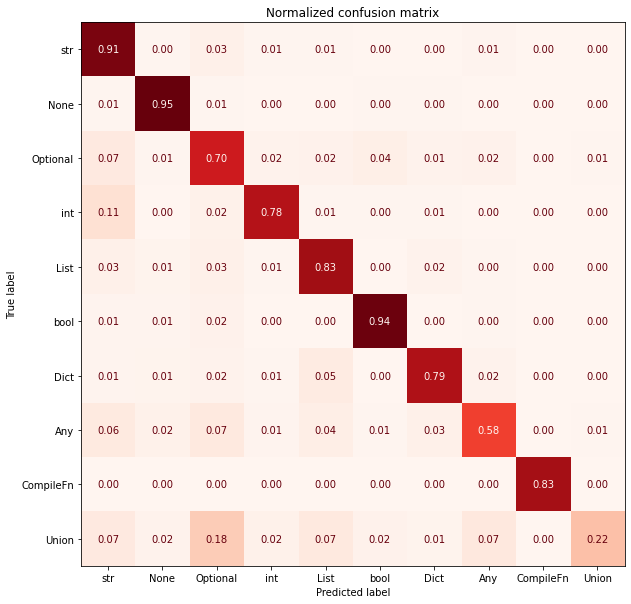

       label  accuracy  count
0        str  0.908608   3009
1       None  0.949255   2148
2   Optional  0.702857   1400
3        int  0.779926   1086
4       List  0.834611    913
5       bool  0.935162    802
6       Dict  0.794118    646
7        Any  0.580135    443
8  CompileFn  0.830049    406
9      Union  0.222222    261

In [16]:
from IPython.display import display_pretty

from spot.type_env import normalize_type_name
from spot.utils import accuracy_by_labels, confusion_matrix_top_k

ConfusionMatrixDisplay.from_predictions

def display_conf_matrix(conf_matrix: dict):
    match conf_matrix:
        case {"matrix": cm, "labels": labels}:
            n_labels = len(labels)
            fig, ax = plt.subplots(figsize=(n_labels, n_labels))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
            disp.plot(cmap="Reds", values_format=".2f", ax=ax, colorbar=False)
            plt.title("Normalized confusion matrix")
            plt.show()


for k in ["loss", "accuracy_partial", "accuracy_full", "n_predictions", "n_labels"]:
    print(f"{k}:", eval_result[f"test_{k}"])

pred_types = list(map(normalize_type_name, eval_result["test_pred_types"]))
label_types = list(map(normalize_type_name, eval_result["test_label_types"]))
conf_matrix = confusion_matrix_top_k(pred_types, label_types, 10)
display_conf_matrix(conf_matrix)
accs = accuracy_by_labels(pred_types, label_types, 10)
stats = []
for t, n in Counter(label_types).most_common(10):
    stats.append({"label": t, "accuracy": accs[t], "count": n})
display_pretty(pd.DataFrame(stats))

In [ ]:
wandb.finish()

eval/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,█▁▁▂▁▁▁▁▁▁▂▁▁▁▂▂▁▂▁
eval/samples_per_second,▁██▇██████▇███▇▇█▇█
eval/steps_per_second,▁██▇██████▇███▇▇█▇█
test/accuracy_full,▁
test/accuracy_partial,▁
test/loss,▁
test/n_labels,▁
test/n_predictions,▁
test/runtime,▁
test/samples_per_second,▁


In [53]:
preds_for_compile_fn = Counter()
for p, l in zip(pred_types, label_types):
    l: str
    if l.strip().endswith('Union'):
        preds_for_compile_fn[p.strip()] += 1

preds_for_compile_fn.most_common()

[('Union', 53),
 ('Optional', 34),
 ('str', 29),
 ('List', 16),
 ('Any', 13),
 ('T', 13),
 ('Tuple', 8),
 ('Expr', 8),
 ('Dict', 7),
 ('int', 6),
 ('bool', 5),
 ('SpecialForm', 5),
 ('Response', 4),
 ('HttpStatusCode', 3),
 ('TypingType', 2),
 ('float', 2),
 ('bytes', 2),
 ('TripDistance', 2),
 ('AvroModel', 2),
 ('BytesIO', 2),
 ('Iterable', 2),
 ('Symbol', 2),
 ('Form', 2),
 ('OASFileType', 1),
 ('Type', 1),
 ('None', 1),
 ('UnusableDataSource', 1),
 ('Vec3D', 1),
 ('Session', 1),
 ('datetime', 1),
 ('StrIntT', 1),
 ('Tensor', 1),
 ('CrawlOut', 1),
 ('S3Storage', 1),
 ('DefaultStorage', 1),
 ('Storage', 1),
 ('UserTypeEnum', 1),
 ('AvroField', 1),
 ('date', 1),
 ('LogicalTypes', 1),
 ('Keyword', 1),
 ('LispReaderForm', 1),
 ('Namespace', 1),
 ('IPersistentList', 1),
 ('DefTypeASTGenerator', 1),
 ('FunctionDef', 1),
 ('ISeq', 1),
 ('Set', 1),
 ('MetaGetter', 1),
 ('IForm', 1),
 ('HostField', 1),
 ('VarRef', 1),
 ('Local', 1),
 ('PyDict', 1),
 ('RV', 1),
 ('Xlsb', 1),
 ('BufferedIOBase